<a href="https://colab.research.google.com/github/ravidipu90/ML_DL-Assignments/blob/main/Bert_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 123 kB 6.8 MB/s 
     |████████████████████████████████| 132 kB 55.4 MB/s 
     |████████████████████████████████| 79 kB 10.5 MB/s 
     |████████████████████████████████| 8.8 MB 59.5 MB/s 
     |████████████████████████████████| 138 kB 73.0 MB/s 
     |████████████████████████████████| 127 kB 75.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import tensorflow as tf

# Check to confirm that GPU is available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError ('GPU device not found')

print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm , trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
df = pd.read_csv ('train_data.csv', delimiter=',', header=None, names=['sentence', 'label'])
df = df.drop(0)
df.shape

(19998, 2)

In [ ]:
df.head()

,sentence,label
1,I am reading score of Mahler is Symphony No . .,0
2,I am not interested in cars or electric applia...,1
3,This is my homework for my English class .,0
4,"In comparison , Canada is catches increased an...",0
5,"Fortunately , my older sister is friend is a d...",1


In [ ]:
sentences = df.sentence.values
sentences = ["[CLS]" + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values.astype(int)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case = True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print("Tokenize version of the the first sentence:")
print(tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 931786.71B/s]


Tokenize version of the the first sentence:
['[', 'cl', '##s', ']', 'i', 'am', 'reading', 'score', 'of', 'ma', '##hler', 'is', 'symphony', 'no', '.', '.', '[SEP]']


In [ ]:
# Padding Sentences
# Set the maximum sequence length. The longest sequence in our training set
# is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 256

# Pad our input tokens
input_ids = pad_sequences(
    [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
    maxlen=MAX_LEN, dtype="long", truncating="post", padding="post"
    )

# Index Numbers and Padding
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# pad sentences
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype ="long", truncating="post",padding ="post")

In [ ]:
# Attention masks

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = \
  train_test_split(input_ids, labels, random_state=2018, test_size=0.2)

train_masks, validation_masks , _, _ = \
  train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.2)

# transform all data into torch tensors
train_inputs = torch.from_numpy(train_inputs)
validation_inputs = torch.from_numpy(validation_inputs)
train_labels = torch.from_numpy(train_labels)
validation_labels = torch.from_numpy(validation_labels)
train_masks = torch.from_numpy(np.array(train_masks))
validation_masks = torch.from_numpy(np.array(validation_masks))

In [ ]:
# Preparation for Training

# Select a batch size for training. For fine tuning BERT on a
# specific task , BERT authors recommend a batch size of 16 or 32
batch_size = 16

# Create an iterator of our data with torch DataLoader
# This helps save on memory during training because, unlike a for loop,
# with iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = \
  DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = \
  TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = \
  DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=3)

model.cuda()

100%|██████████| 407873900/407873900 [00:12<00:00, 33366320.95B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [ ]:
# Hyperparameters

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']

optimizer_grouped_parameters = [
    {
        'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01
    },
    {
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.00
    }
  ]

optimizer = BertAdam(optimizer_grouped_parameters, lr=2e-6, warmup=0.1)

t_total value of -1 results in schedule not being applied


In [ ]:
# calculates the accuracy of our predictions vs labels

def flat_accuracy(preds, labels):
  pred_flat  = np.argmax(preds , axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat)/len(labels_flat)

In [ ]:
# Training Loop

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 6
# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  # Training
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask , b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None,
                 attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))

# Validation
# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

# Tracking variables
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients,
  # ve memory and speede up validation
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids =None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  tmp_eval_accuracy = flat_accuracy(logits, label_ids)
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1

print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:  17%|█▋        | 1/6 [14:08<1:10:44, 848.96s/it]

Train loss: 0.6758443422913551


Epoch:  33%|███▎      | 2/6 [28:17<56:34, 848.65s/it]  

Train loss: 0.6263031465411186


Epoch:  50%|█████     | 3/6 [42:26<42:26, 848.73s/it]

Train loss: 0.6036113116145134


Epoch:  67%|██████▋   | 4/6 [56:34<28:17, 848.67s/it]

Train loss: 0.5864985023736954


Epoch:  83%|████████▎ | 5/6 [1:10:43<14:08, 848.64s/it]

Train loss: 0.5673371410667897


Epoch: 100%|██████████| 6/6 [1:24:52<00:00, 848.79s/it]

Train loss: 0.5569032430052757


Validation Accuracy: 0.602


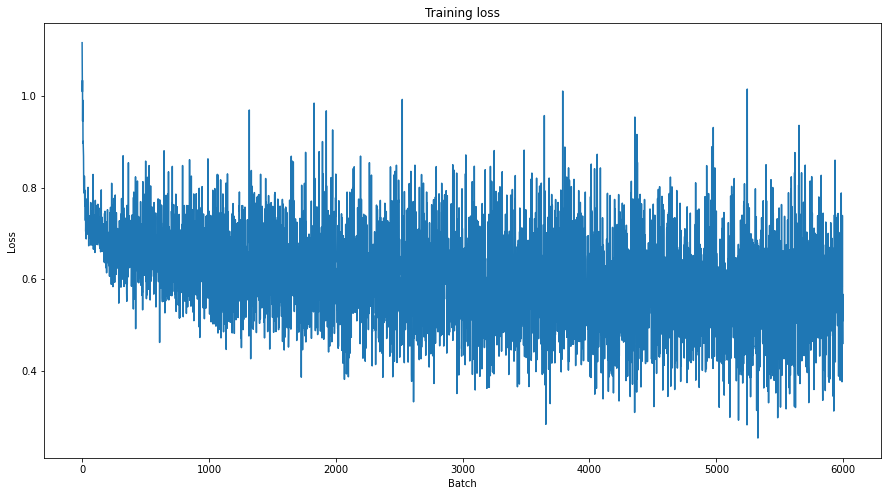

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
df = pd.read_csv("val_data.csv", delimiter=',', header=None,
  names=['sentence', 'label'])
df = df.drop(0)
# Create sentence) and label lists
sentences = df.sentence.values
# We need to add special tokens at the beginning and end of each sentence
# for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values.astype(int)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# Padding Sentences
# Set the maximum sequence length. The longest sequence in our training set
# is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 256

# Pad our input tokens
input_ids = pad_sequences(
    [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
    maxlen=MAX_LEN, dtype="long", truncating="post", padding="post"
    )

# Index Numbers and Padding
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# pad sentences
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype ="long", truncating="post",padding ="post")

# Attention masks

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32

prediction_data = \
  TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = \
  DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [ ]:
# Prediction on the test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask , b_labels = batch
  # Telling the model not to compute or store gradients,
  # saving memory and speeding up prediction

  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to("cpu").numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [ ]:
# Evaluate Each Test Batch using Matthew's correlation coefficient

from sklearn.metrics import matthews_corrcoef

matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                               np.argmax(predictions[i], axis=1).flatten())

  matthews_set.append(matthews)

matthews_set

[0.13483997249264842,
 0.048647332992624304,
 0.31814238148788887,
 0.1286949299057178,
 0.060522753266880246,
 0.29554655870445345,
 0.3872983346207417,
 0.3316863613133475,
 0.3307292642388204,
 0.24039295346263034,
 0.5067911605056783,
 0.3567530340063379,
 0.1814627428602745,
 0.3803921568627451,
 0.1807753815155468,
 -0.011953709238683663,
 0.19738550848793068,
 0.1773241389867146,
 0.00857966199371452,
 0.4236592728681617,
 0.10822510822510822,
 0.11500161355436699,
 0.374943053707453,
 0.2886751345948129,
 0.011953709238683663,
 -0.25308553412176554,
 0.21821789023599236,
 0.26967994498529685,
 -0.1286949299057178,
 0.0,
 0.01642880193633814,
 0.11891767800211263,
 0.21469801604867728,
 0.5479936938801236,
 0.05855400437691199,
 0.2792896329177484,
 0.048507125007266595,
 0.5238095238095238,
 0.5174307236488221,
 -0.08973031700969425,
 0.3730235484764954,
 0.26226526415648105,
 0.12909944487358055,
 -0.050964719143762556,
 0.06666666666666667,
 0.5266597241998389,
 0.03046791792

In [ ]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

matthews_corrcoef(flat_true_labels , flat_predictions)

0.2073370259165254

In [ ]:
torch.save(model.state_dict(), 'bert-based-uncased-GED.pth')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp bert-based-uncased-GED.pth './drive/My Drive/Colab Notebooks/S89A'

In [ ]:
# run on a sample text

model.eval()

# Create sentence) and label lists
sentences = ["They drank the pub."]
# We need to add special tokens at the beginning and end of each sentence
# for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels =[0]

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

# Padding Sentences
# Set the maximum sequence length. The longest sequence in our training set
# is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 256

predictions = []
true_labels = []

# Pad our input tokens
input_ids = pad_sequences(
    [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
    maxlen=MAX_LEN, dtype="long", truncating="post", padding="post"
    )

# Index Numbers and Padding
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# pad sentences
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype ="long", truncating="post",padding ="post")

# Attention masks

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
print(prediction_inputs)
print(prediction_masks)

# Put model in evaluation mode
model.eval()

with torch.no_grad():
  # Forward pass, calculate logit predictions
  logits = model(prediction_inputs.to(device), token_type_ids=None, attention_mask=prediction_masks.to(device))

# Move logits and labels to CPU
logits = logits.detach().cpu().numpy()
label_ids = b_labels.to("cpu").numpy()

# Store predictions and true labels
predictions.append(logits)
true_labels.append(label_ids)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

tensor([[  101,  2027, 10749,  1996,  9047,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [ ]:
!pip install gputil

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=2860f446c5f17ba6b53d8ec72a0dbb5016ae228ecbaa2b82529277e124159ad1
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [ ]:
# run on a sample text

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

#free_gpu_cache()

test = pd.read_csv("test_data.csv")
sentences=["I am hero"]
for i in range(len(test['input'])):
    sentences.append(test['input'][i])

#model.eval()

# Create sentence) and label lists
# We need to add special tokens at the beginning and end of each sentence
# for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels =[0]
#print(sentences)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
#print(tokenized_texts)
# Padding Sentences
# Set the maximum sequence length. The longest sequence in our training set
# is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 256

predictions = []
true_labels = []

# Pad our input tokens
input_ids = pad_sequences(
    [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
    maxlen=MAX_LEN, dtype="long", truncating="post", padding="post"
    )

# Index Numbers and Padding
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
#print(input_ids)
# pad sentences
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype ="long", truncating="post",padding ="post")
#print(input_ids)

#print(len(input_ids))
# Attention masks

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i > 0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
batch_size = 32

prediction_data = \
  TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = \
  DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

#print(prediction_masks)
#print(prediction_inputs.shape)
#print(prediction_masks.shape)
# Put model in evaluation mode
model.eval()

with torch.no_grad():
  # Forward pass, calculate logit predictions
  for prediction_input,prediction_mask in prediction_dataloader:
    logits = model(prediction_input.to(device), token_type_ids=None, attention_mask=prediction_mask.to(device))


    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Store predictions and true labels
    predictions.append(logits)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
print(flat_predictions)


Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (866 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (866 > 512). Running this sequence through BERT will result in indexing errors


[1 1 1 ... 1 1 0]


In [ ]:
df.to_csv("/content/test_NEW_data.csv", index=False)

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score

In [ ]:
precision_score(y_test,y_pred1,average='weighted')

NameError: ignored